In [29]:
import os
from pathlib import Path
import polars as pl
import numpy as np
import pandas as pd
from typing import List, Any
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoost, CatBoostClassifier, CatBoostRanker

import torch


In [ ]:
from lightfm import LightFM

In [ ]:
import optuna
import scipy.sparse as sp
import faiss
import implicit

In [ ]:
 # добавление корня проекта
root_path = Path().absolute().parent
os.chdir(str(root_path))

In [ ]:
from src.metrics import user_recall, user_ndcg
from src.helper import set_seed, get_recommendations

In [ ]:
# будем использовать cuda, если доступны вычисления на gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [ ]:
TOP_K = 10
RANDOM_STATE = 1
N_TRIALS = 20

In [ ]:
set_seed(RANDOM_STATE)

## Описание данных

### ad_features

| Поле            | Тип                  | Описание                                 |
|---              |---                   |---                                       |
| adgroup_id      | int                  | Идентификатор рекламы                    |
| cate_id         | int                  | Идентификатор категории                  |
| campaign_id     | int                  | Идентификатор рекламной компании         |
| customer        | int                  | Идентификатор рекламодателя              |
| brand           | str                  | Идентификатор бренда                     |
| price           | int                  | Цена товара                              |

Рекламное объявление принадлежит одному товару, при этом у товара есть бренд и категория\


### user_features

| Поле            | Тип                  | Описание                                 |
|---              |---                   |---                                       |
| userid          | int                  | Идентификатор пользователя               |
| cms_segid       | int                  | Идентификатор сегментированной группы пользователей|
| cms_group_id    | int                  | Идентификатор группы пользователей       |
| final_gender_code | int                | Пол пользователя (мужской – 1, женский – 2)|
| age_level       | int                  | Категория возраста пользователя          |
| pvalue_level    | int                  | Уровень потребления                      |
| shopping_level  | int                  | Уровень вовлеченности (значения из диапазона 1-3 от слабой до сильной) |
| occupation      | int                  | Род занятости (студент или нет)          |
| new_user_class_level | int             | Населенность города проживания           |

### behavioral_logs

| Поле            | Тип                  | Описание                                 |
|---              |---                   |---                                       |
| user            | int                  | Идентификатор пользователя               |
| time_stamp      | int                  | Время                                    |
| btag            | str                  | Тип действия (**pv**: просмотр, **cart**: добавление в корзину, **fav**: добавление в избранное, **buy**: покупка) |
| cate            | int                  | Идентификатор категории                  |
| brand           | str                  | Идентификатор бренда                     |


### data

| Поле            | Тип                  | Описание                                 |
|---              |---                   |---                                       |
| user            | int                  | Идентификатор пользователя               |
| time_stamp      | int                  | Время                                    |
| adgroup_id      | int                  | Идентификатор рекламы                    |
| clk             | int                  | Был ли клик?                             |

## Оценивание

В качестве метрики качества используется ndcg@10. Чтобы получить максимальный балл, достаточно добиться ndcg@10 = 0.03

В качестве `y_relevant` используется те рекламные объявления, по которым были клики после собранной истории взаимодействий

In [38]:
def create_submission(test: pd.DataFrame, recs: np.ndarray, postfix: str):
    "Создать файл для сабмита по матрице рекомендаций"
    submission = [(i, list(j)) for i, j in zip(test['user_id'].to_list(), recs[test['user_id'].to_list()])]
    submission = pl.DataFrame(submission, schema=['user_id', 'y_rec'])
    submission.write_parquet(f'hw_9/submission_{postfix}.parquet')
    return submission

# Данные

In [9]:
ad_features = pl.read_parquet('hw_9/ad_features.parquet')
user_features = pl.read_parquet('hw_9/user_features.parquet').rename({"userid": "user"})
behavioral_logs = pl.read_parquet('hw_9/behavior_logs.parquet')
data = pl.read_parquet('hw_9/train.parquet')
test = pl.read_parquet('hw_9/test.parquet')

In [10]:
data = data.sort('time_stamp')
timestamp_threshold = data['time_stamp'].quantile(0.9)

In [11]:
behavioral_train_logs = (
    behavioral_logs
    .group_by('user', 'btag')
    .count()
    .pivot('btag',index='user',  values='count')
    .fill_null(0)
)

data_reach = (
    pl.concat([
        data.filter(pl.col('clk')==1),
        data.filter(pl.col('clk')==0).sample(1232013*6)
    ])
    .join(ad_features, on='adgroup_id')
    .join(user_features, on='user')
    .join(behavioral_train_logs, on='user')
    .drop(['time_stamp'])

)
train_reach_df, test_reach_df = train_test_split(
    data_reach, test_size=0.1, random_state=RANDOM_STATE
)

/tmp/ipykernel_34753/1053290861.py:2: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  behavioral_logs


In [12]:

train_df = data.filter(pl.col('time_stamp') <= timestamp_threshold)
test_df = data.filter(pl.col('time_stamp') > timestamp_threshold)

In [13]:
grouped_df = (
    data
    # релевантны только те объекты, для которых был клик
    .filter(pl.col('clk') == 1)
    .group_by('user')
    .agg(pl.col('adgroup_id').alias('y_rel'))
)
print(grouped_df.shape)
grouped_df.head()

(459691, 2)


user,y_rel
i64,list[i64]
285763,"[366821, 635042, … 781111]"
1059265,"[698813, 464812]"
165162,"[679193, 485603]"
546088,[371582]
1081416,[115505]


In [14]:
train_grouped_df = (
    train_df
    # релевантны только те объекты, для которых был клик
    .filter(pl.col('clk') == 1)
    .group_by('user')
    .agg(pl.col('adgroup_id').alias('y_rel'))
)
print(train_grouped_df.shape)
train_grouped_df.head()

(430253, 2)


user,y_rel
i64,list[i64]
711241,"[272619, 693115, … 647990]"
650692,"[508106, 484809, … 790412]"
465740,"[511123, 688970, 333213]"
401499,"[741585, 601772, 730196]"
676648,[674268]


In [15]:
test_grouped_df = (
    test_df
    .filter(pl.col('clk') == 1)
    .group_by('user')
    .agg(pl.col('adgroup_id').alias('y_rel'))
    .join(
        train_df
        .filter(pl.col('clk') == 1)
        .group_by('user')
        .agg(pl.col('adgroup_id').alias('user_history')),
        'user',
        how='left'
    )
)
print(test_grouped_df.shape)
print(test_grouped_df.filter(pl.col('user_history').is_not_null()).shape)
# Для теста по кандидаттам только не нулевые значения
test_nonull_grouped_df = test_grouped_df.filter(pl.col('user_history').is_not_null())
test_grouped_df.head()

(80167, 3)
(50729, 3)


user,y_rel,user_history
i64,list[i64],list[i64]
1083509,"[451943, 181000]",null
1112609,[606005],"[721278, 491523]"
132528,[744809],[598676]
830264,[770860],null
5910,"[836114, 448469, 624074]","[622385, 705171, … 498540]"


In [16]:
median_seq_len = int(train_grouped_df['y_rel'].map_elements(len).median())
max_seq_len = int(train_grouped_df['y_rel'].map_elements(len).max())
print(f"среднее кол-во реклам {median_seq_len}")
print(f"максимальное кол-во реклам {max_seq_len}")

/tmp/ipykernel_34753/530598196.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  median_seq_len = int(train_grouped_df['y_rel'].map_elements(len).median())
/tmp/ipykernel_34753/530598196.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  max_seq_len = int(train_grouped_df['y_rel'].map_elements(len).max())


среднее кол-во реклам 1
максимальное кол-во реклам 152


## Бейзлайн с использованием behavioral logs

В качестве простого бейзлайна для каждого пользователя найдем категорию рекламных объявлений, наиболее интересную ему. Затем для каждой категории найдем самые популярные по метрике `ctr` (Click-through rate).

In [114]:
def get_top_candidates(x: List[dict]) -> List[int]:
    """
    Для списка структур с полями ctr и adgroup_id сортирует его по убыванию ctr и возвращает
    TOP_K соответствующих идентификаторов adgroup_id
    """
    x = sorted(x, key=lambda v: -v['ctr'])[:TOP_K]
    return list(map(lambda x: x['adgroup_id'], x))


In [108]:
# веса примерно соответствуют behavioral_logs['btag'].value_counts()
weight_dict = {
    'pv': 1,
    'cart': 40,
    'fav': 80,
    'buy': 80
}

behavioral_logs_top_categories = (
    behavioral_logs
    # для валидации отфильтруем все события как в тренировочной выборке
    .filter(pl.col('time_stamp') <= timestamp_threshold)
     # каждое событие преобразуем в вес
    .with_columns([pl.col('btag').map_elements(weight_dict.get).alias('weight')])
    .group_by('user', 'cate')
    # итоговый вес для категории – сумма весов событий
    .agg(pl.col('weight').sum())
    # для каждого пользователя оставим категорию с максимальным весом
    .sort(['user', 'weight'], descending=True)
    .unique('user', keep='first')
)
behavioral_logs_top_categories

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

user,cate,weight
i64,i64,i64
1141729,4283,166
1141726,4505,5
1141725,10905,93
1141724,4385,135
1141723,6421,14
…,…,…
5,7081,1
4,4281,4
3,6511,16


In [9]:
grouped_tops = (
    train_df
    .join(ad_features, on='adgroup_id')
    # для пары cate_id и adgroup_id вычисляем ctr
    .group_by('cate_id', 'adgroup_id')
    .agg([
        pl.col('clk').mean().alias('ctr'),
        pl.count().alias('count')
    ])
    # уберем те рекламные объявления, которые были показаны всего N раз
    .filter(pl.col('count') > 1)
    # сгруппируем ctr и adgroup_id в словарь и вызовем функцию get_top_candidates
    .with_columns([pl.struct(ctr=pl.col('ctr'), adgroup_id=pl.col('adgroup_id')).alias('struct')])
    .group_by('cate_id')
    .agg(pl.col('struct').map_elements(get_top_candidates).alias('y_rec'))
)
grouped_tops

/tmp/ipykernel_911/3087662466.py:16: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('count')
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


cate_id,y_rec
i64,list[i64]
6,"[2772, 653833, … 560284]"
8926,[287969]
8000,"[7518, 49455, … 541926]"
10230,"[211586, 84736]"
4722,"[188871, 150947, … 629129]"
…,…
250,[299451]
4847,"[420825, 260348, … 227571]"
4314,"[493256, 564782, … 737917]"


In [10]:
recs = (
    test
    .join(behavioral_logs_top_categories, left_on='user_id', right_on='user')
    .join(grouped_tops, left_on='cate', right_on='cate_id')
    .select('user_id', 'y_rec')
)
recs

user_id,y_rec
i64,list[i64]
1141720,"[692584, 511663, … 348929]"
1141714,"[725297, 98564, … 353779]"
1141710,"[196526, 148340, … 151029]"
1141709,"[518334, 327446, … 520157]"
1141708,"[721068, 700091, … 435257]"
…,…
16,"[640339, 503386, … 696553]"
15,"[309055, 591788, … 295896]"
7,"[117050, 671331, … 294064]"


In [12]:
test_grouped_df = (
    test_df
    # релевантны только те объекты, для которых был клик
    .filter(pl.col('clk') == 1)
    .group_by('user')
    .agg(pl.col('adgroup_id').alias('y_rel'))
)

ndcg_list = []
recall_list = []
for _, y_rel, y_rec in test_grouped_df.join(recs, left_on='user', right_on='user_id').rows():
    ndcg_list.append(user_ndcg(y_rel, y_rec))
    recall_list.append(user_recall(y_rel, y_rec))
    
mean_ndcg = np.mean(ndcg_list)
mean_recall = np.mean(recall_list)
print(f'NDCG@{TOP_K} = {mean_ndcg:.4f}, Recall@{TOP_K} = {mean_recall:.4f}')

NDCG@10 = 0.0007, Recall@10 = 0.0015


Построим рекомендации по всем данным

In [109]:
behavioral_logs_top_categories = (
    behavioral_logs
     # каждое событие преобразуем в вес
    .with_columns([pl.col('btag').map_elements(weight_dict.get).alias('weight')])
    .groupby('user', 'cate')
    # итоговый вес для категории – сумма весов событий
    .agg(pl.col('weight').sum())
    # для каждого пользователя оставим категорию с максимальным весом
    .sort(['user', 'weight'], descending=True)
    .unique('user', keep='first')
)
behavioral_logs_top_categories

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

AttributeError: 'DataFrame' object has no attribute 'groupby'

In [115]:
grouped_tops = (
    data
    .join(ad_features, on='adgroup_id')
    # для пары cate_id и adgroup_id вычисляем ctr
    .group_by('cate_id', 'adgroup_id')
    .agg([
        pl.col('clk').mean().alias('ctr'),
        pl.count().alias('count')
    ])
    # уберем те рекламные объявления, которые были показаны всего N раз
    .filter(pl.col('count') > 1)
    # сгруппируем ctr и adgroup_id в словарь и вызовем функцию get_top_candidates
    .with_columns([pl.struct(ctr=pl.col('ctr'), adgroup_id=pl.col('adgroup_id')).alias('struct')])
    .group_by('cate_id')
    .agg(pl.col('struct').map_elements(get_top_candidates).alias('y_rec'))
)
grouped_tops

/tmp/ipykernel_322/2590387304.py:8: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('count')
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


cate_id,y_rec
i64,list[i64]
5383,"[662209, 581523, … 845753]"
10891,"[73473, 249714, … 205580]"
8131,"[532748, 315409, … 153827]"
4594,"[388624, 558660, … 16980]"
3,"[284364, 117227, … 176766]"
…,…
6547,"[98025, 228897, … 342134]"
6157,"[531839, 372923, … 299132]"
11790,"[668880, 576879, 820375]"


In [116]:
(
    test
    .join(behavioral_logs_top_categories, left_on='user_id', right_on='user')
    .join(grouped_tops, left_on='cate', right_on='cate_id')
    .select('user_id', 'y_rec')
    .write_parquet('submission.parquet')
)

# Двухуровневая модель

## LightFM

In [17]:
# соберем строчки для разреженной матрицы
rows = []
cols = []
values = []

for user_id, train_item_ids in train_grouped_df.select('user', 'y_rel').rows():
    rows.extend([user_id] * len(train_item_ids))
    cols.extend(train_item_ids)
    values.extend([1]*len(train_item_ids))

user_item_train = sp.csr_matrix((values, (rows, cols)), dtype=np.float32)
user_item_train

<1141730x846798 sparse matrix of type '<class 'numpy.float32'>'
	with 1087513 stored elements in Compressed Sparse Row format>

In [ ]:
def objective(trial):
    no_components = trial.suggest_int('no_components', 8, 128)
    epochs = trial.suggest_int('epochs', 5, 50)
    # loss = trial.suggest_categorical('loss', ['logistic', 'bpr', 'warp', 'warp-kos'])
    alpha = trial.suggest_float('alpha', 0., 1e-3)
        
    print({
        'no_components': no_components,
        'alpha': alpha,
        # 'loss': loss,
    })
    
    try:
        # модель может бросить исключение, если регуляризация слишком сильная
        lightfm_model = LightFM(
            no_components=no_components,
            loss='warp',
            item_alpha=alpha,
            user_alpha=alpha,
            k=TOP_K,
            random_state=RANDOM_STATE,
        )
        lightfm_model.fit(user_item_train, epochs=5, verbose=True)
    except:
        return None
    _, recs = get_recommendations(
        lightfm_model.user_embeddings,
        lightfm_model.item_embeddings,
        TOP_K
    )


    recall_list = []
    for user_id, y_rel, user_history in test_nonull_grouped_df.rows():
        # y_rec = [item_id for item_id in recs[user_id] if item_id not in user_history]
        # если не фильтровать историю, то метрики будут расти
        y_rec = recs[user_id]

        recall_list.append(user_recall(y_rel, y_rec))
    mean_recall = np.mean(recall_list)
    print(f'RECALL@{TOP_K} = {mean_recall}')
    return mean_recall
    

study = optuna.create_study(directions=('maximize',))
study.optimize(objective, n_trials=25)

study.best_params

In [ ]:
study.best_params


In [21]:
# Обучение модели на всем наборе данных
rows = []
cols = []
values = []

for user_id, train_item_ids in grouped_df.select('user', 'y_rel').rows():
    rows.extend([user_id] * len(train_item_ids))
    cols.extend(train_item_ids)
    values.extend([1]*len(train_item_ids))

user_item_data = sp.csr_matrix((values, (rows, cols)), dtype=np.float32)

lightfm_model = LightFM(
            **{
                'no_components': 128,
                'loss': 'warp',
                'item_alpha': 1.9398897222457625e-05,
                'user_alpha': 1.9398897222457625e-05,
              },
            k=TOP_K,
            random_state=RANDOM_STATE,
        )
lightfm_model.fit(user_item_train, epochs=30, verbose=True)

_, final_lfm_recs = get_recommendations(
        lightfm_model.user_embeddings,
        lightfm_model.item_embeddings,
        TOP_K
    )

Epoch: 100%|██████████| 30/30 [07:29<00:00, 14.99s/it]


In [39]:
submission_lfm = create_submission(test, final_lfm_recs, 'lfm')

Уже этот подбор выбивает max нужных метрик\
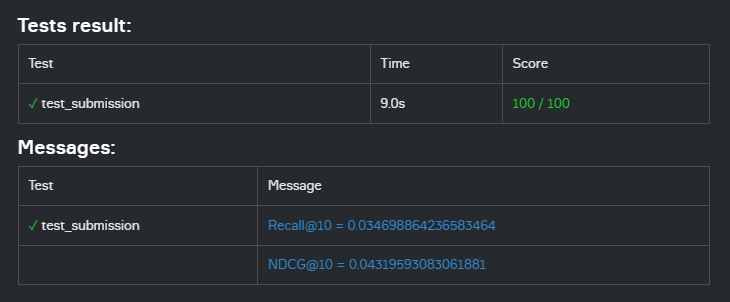

## ALS

In [16]:
# соберем строчки для разреженной матрицы
rows = []
cols = []
values = []

for user_id, train_item_ids in train_grouped_df.select('user', 'y_rel').rows():
    rows.extend([user_id] * len(train_item_ids))
    cols.extend(train_item_ids)
    values.extend([1]*len(train_item_ids))

user_item_train = sp.csr_matrix((values, (rows, cols)), dtype=np.float32)
user_item_train

<1141730x846798 sparse matrix of type '<class 'numpy.float32'>'
	with 1087513 stored elements in Compressed Sparse Row format>

In [54]:
def objective(trial):
    factors = trial.suggest_int('factors', 8, 128)
    iterations = trial.suggest_int('iterations', 5, 30)
    alpha = trial.suggest_float('alpha', 0.1, 5.0)
    regularization = trial.suggest_float('regularization', 1e-3, 1.0)
        
    print({
        'factors': factors,
        'iterations': iterations,
        'alpha': alpha,
        'regularization': regularization,
    })
    
    set_seed()
    als_model = implicit.als.AlternatingLeastSquares(
        factors=factors,
        iterations=iterations,
        random_state=RANDOM_STATE,
        alpha=alpha,
        regularization=regularization
    )
    als_model.fit(user_item_train)
    
    _, recs = get_recommendations(
        als_model.user_factors.to_numpy(),
        als_model.item_factors.to_numpy(),
        TOP_K + median_seq_len
    )
    
    recall_list = []
    for user_id, y_rel, user_history in test_nonull_grouped_df.rows():
        # y_rec = [item_id for item_id in recs[user_id] if item_id not in user_history]
        # если не фильтровать историю, то метрики будут расти
        y_rec = recs[user_id]

        recall_list.append(user_recall(y_rel, y_rec))
    mean_recall = np.mean(recall_list)
    print(f'RECALL@{TOP_K} = {mean_recall}')
    return mean_recall
    
    
study = optuna.create_study(directions=('maximize',))
study.optimize(objective, n_trials=N_TRIALS)

study.best_params

[I 2024-09-04 11:43:21,996] A new study created in memory with name: no-name-81114849-3935-46b5-bcbc-3088ba602e1b


{'factors': 45, 'iterations': 7, 'alpha': 0.608821044692731, 'regularization': 0.278987185483607}


  0%|          | 0/7 [00:00<?, ?it/s]

[I 2024-09-04 11:43:42,431] Trial 0 finished with value: 0.01823933202207956 and parameters: {'factors': 45, 'iterations': 7, 'alpha': 0.608821044692731, 'regularization': 0.278987185483607}. Best is trial 0 with value: 0.01823933202207956.


RECALL@10 = 0.01823933202207956
{'factors': 13, 'iterations': 10, 'alpha': 1.9338635003521834, 'regularization': 0.4626156681978764}


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-09-04 11:43:59,850] Trial 1 finished with value: 0.01721952369321086 and parameters: {'factors': 13, 'iterations': 10, 'alpha': 1.9338635003521834, 'regularization': 0.4626156681978764}. Best is trial 0 with value: 0.01823933202207956.


RECALL@10 = 0.01721952369321086
{'factors': 101, 'iterations': 22, 'alpha': 4.013124210872325, 'regularization': 0.23194142776583826}


  0%|          | 0/22 [00:00<?, ?it/s]

[I 2024-09-04 11:44:27,459] Trial 2 finished with value: 0.019787896912064624 and parameters: {'factors': 101, 'iterations': 22, 'alpha': 4.013124210872325, 'regularization': 0.23194142776583826}. Best is trial 2 with value: 0.019787896912064624.


RECALL@10 = 0.019787896912064624
{'factors': 35, 'iterations': 21, 'alpha': 1.0835508031368983, 'regularization': 0.4214241443410679}


  0%|          | 0/21 [00:00<?, ?it/s]

[I 2024-09-04 11:44:46,849] Trial 3 finished with value: 0.018105343360485162 and parameters: {'factors': 35, 'iterations': 21, 'alpha': 1.0835508031368983, 'regularization': 0.4214241443410679}. Best is trial 2 with value: 0.019787896912064624.


RECALL@10 = 0.018105343360485162
{'factors': 27, 'iterations': 18, 'alpha': 0.5458818531491876, 'regularization': 0.1914664568153294}


  0%|          | 0/18 [00:00<?, ?it/s]

[I 2024-09-04 11:45:04,484] Trial 4 finished with value: 0.017620086733770985 and parameters: {'factors': 27, 'iterations': 18, 'alpha': 0.5458818531491876, 'regularization': 0.1914664568153294}. Best is trial 2 with value: 0.019787896912064624.


RECALL@10 = 0.017620086733770985
{'factors': 106, 'iterations': 28, 'alpha': 1.9386667338014445, 'regularization': 0.7392945607517408}


  0%|          | 0/28 [00:00<?, ?it/s]

[I 2024-09-04 11:45:32,970] Trial 5 finished with value: 0.020493848723399946 and parameters: {'factors': 106, 'iterations': 28, 'alpha': 1.9386667338014445, 'regularization': 0.7392945607517408}. Best is trial 5 with value: 0.020493848723399946.


RECALL@10 = 0.020493848723399946
{'factors': 94, 'iterations': 18, 'alpha': 2.0567316484007074, 'regularization': 0.41293260449273406}


  0%|          | 0/18 [00:00<?, ?it/s]

[I 2024-09-04 11:45:59,574] Trial 6 finished with value: 0.019680097809581697 and parameters: {'factors': 94, 'iterations': 18, 'alpha': 2.0567316484007074, 'regularization': 0.41293260449273406}. Best is trial 5 with value: 0.020493848723399946.


RECALL@10 = 0.019680097809581697
{'factors': 53, 'iterations': 20, 'alpha': 0.7868881501919407, 'regularization': 0.4171559075734231}


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-09-04 11:46:20,521] Trial 7 finished with value: 0.019828580689922326 and parameters: {'factors': 53, 'iterations': 20, 'alpha': 0.7868881501919407, 'regularization': 0.4171559075734231}. Best is trial 5 with value: 0.020493848723399946.


RECALL@10 = 0.019828580689922326
{'factors': 66, 'iterations': 14, 'alpha': 3.774496818028264, 'regularization': 0.9132179668448115}


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2024-09-04 11:46:43,849] Trial 8 finished with value: 0.019594998226993735 and parameters: {'factors': 66, 'iterations': 14, 'alpha': 3.774496818028264, 'regularization': 0.9132179668448115}. Best is trial 5 with value: 0.020493848723399946.


RECALL@10 = 0.019594998226993735
{'factors': 119, 'iterations': 21, 'alpha': 0.4464176686501199, 'regularization': 0.1180448306737027}


  0%|          | 0/21 [00:00<?, ?it/s]

[I 2024-09-04 11:47:14,055] Trial 9 finished with value: 0.021204817180900285 and parameters: {'factors': 119, 'iterations': 21, 'alpha': 0.4464176686501199, 'regularization': 0.1180448306737027}. Best is trial 9 with value: 0.021204817180900285.


RECALL@10 = 0.021204817180900285
{'factors': 120, 'iterations': 30, 'alpha': 4.9214552030757215, 'regularization': 0.0499446565056461}


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-09-04 11:47:42,977] Trial 10 finished with value: 0.021464918482565588 and parameters: {'factors': 120, 'iterations': 30, 'alpha': 4.9214552030757215, 'regularization': 0.0499446565056461}. Best is trial 10 with value: 0.021464918482565588.


RECALL@10 = 0.021464918482565588
{'factors': 127, 'iterations': 29, 'alpha': 3.265026630944163, 'regularization': 0.06495463941010439}


  0%|          | 0/29 [00:00<?, ?it/s]

[I 2024-09-04 11:48:14,519] Trial 11 finished with value: 0.02154659850290176 and parameters: {'factors': 127, 'iterations': 29, 'alpha': 3.265026630944163, 'regularization': 0.06495463941010439}. Best is trial 11 with value: 0.02154659850290176.


RECALL@10 = 0.02154659850290176
{'factors': 124, 'iterations': 30, 'alpha': 4.76327853557861, 'regularization': 0.02784012583118769}


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-09-04 11:48:46,335] Trial 12 finished with value: 0.02126616376689124 and parameters: {'factors': 124, 'iterations': 30, 'alpha': 4.76327853557861, 'regularization': 0.02784012583118769}. Best is trial 11 with value: 0.02154659850290176.


RECALL@10 = 0.02126616376689124
{'factors': 84, 'iterations': 26, 'alpha': 3.246820529208734, 'regularization': 0.0094835704957284}


  0%|          | 0/26 [00:00<?, ?it/s]

[I 2024-09-04 11:49:11,342] Trial 13 finished with value: 0.019411669246712396 and parameters: {'factors': 84, 'iterations': 26, 'alpha': 3.246820529208734, 'regularization': 0.0094835704957284}. Best is trial 11 with value: 0.02154659850290176.


RECALL@10 = 0.019411669246712396
{'factors': 127, 'iterations': 25, 'alpha': 4.851489461612585, 'regularization': 0.6888204655539273}


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-09-04 11:49:43,202] Trial 14 finished with value: 0.021709120741528084 and parameters: {'factors': 127, 'iterations': 25, 'alpha': 4.851489461612585, 'regularization': 0.6888204655539273}. Best is trial 14 with value: 0.021709120741528084.


RECALL@10 = 0.021709120741528084
{'factors': 78, 'iterations': 26, 'alpha': 2.8948190277210446, 'regularization': 0.6336342838944586}


  0%|          | 0/26 [00:00<?, ?it/s]

[I 2024-09-04 11:50:07,688] Trial 15 finished with value: 0.01955888012997981 and parameters: {'factors': 78, 'iterations': 26, 'alpha': 2.8948190277210446, 'regularization': 0.6336342838944586}. Best is trial 14 with value: 0.021709120741528084.


RECALL@10 = 0.01955888012997981
{'factors': 110, 'iterations': 25, 'alpha': 4.144684836165138, 'regularization': 0.6501777558807267}


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2024-09-04 11:50:36,170] Trial 16 finished with value: 0.02060184833990381 and parameters: {'factors': 110, 'iterations': 25, 'alpha': 4.144684836165138, 'regularization': 0.6501777558807267}. Best is trial 14 with value: 0.021709120741528084.


RECALL@10 = 0.02060184833990381
{'factors': 127, 'iterations': 24, 'alpha': 3.3196930014289734, 'regularization': 0.9948517844348412}


  0%|          | 0/24 [00:00<?, ?it/s]

[I 2024-09-04 11:51:07,604] Trial 17 finished with value: 0.021640948032952453 and parameters: {'factors': 127, 'iterations': 24, 'alpha': 3.3196930014289734, 'regularization': 0.9948517844348412}. Best is trial 14 with value: 0.021709120741528084.


RECALL@10 = 0.021640948032952453
{'factors': 91, 'iterations': 14, 'alpha': 4.44465895210016, 'regularization': 0.9900096998294954}


  0%|          | 0/14 [00:00<?, ?it/s]

[I 2024-09-04 11:51:34,013] Trial 18 finished with value: 0.019762184278671966 and parameters: {'factors': 91, 'iterations': 14, 'alpha': 4.44465895210016, 'regularization': 0.9900096998294954}. Best is trial 14 with value: 0.021709120741528084.


RECALL@10 = 0.019762184278671966
{'factors': 71, 'iterations': 24, 'alpha': 3.5456753932572695, 'regularization': 0.8194643885735088}


  0%|          | 0/24 [00:00<?, ?it/s]

[I 2024-09-04 11:51:57,579] Trial 19 finished with value: 0.01928518236961139 and parameters: {'factors': 71, 'iterations': 24, 'alpha': 3.5456753932572695, 'regularization': 0.8194643885735088}. Best is trial 14 with value: 0.021709120741528084.


RECALL@10 = 0.01928518236961139


{'factors': 127,
 'iterations': 25,
 'alpha': 4.851489461612585,
 'regularization': 0.6888204655539273}

In [56]:
study.best_params

{'factors': 127,
 'iterations': 25,
 'alpha': 4.851489461612585,
 'regularization': 0.6888204655539273}

In [33]:
# Обучение модели на всем наборе данных
rows = []
cols = []
values = []

for user_id, train_item_ids in grouped_df.select('user', 'y_rel').rows():
    rows.extend([user_id] * len(train_item_ids))
    cols.extend(train_item_ids)
    values.extend([1]*len(train_item_ids))

user_item_data = sp.csr_matrix((values, (rows, cols)), dtype=np.float32)

als_model = implicit.als.AlternatingLeastSquares(
    **{'factors': 127,
 'iterations': 25,
 'alpha': 4.851489461612585,
 'regularization': 0.6888204655539273},
    random_state=RANDOM_STATE,
)

als_model.fit(user_item_data)

  0%|          | 0/25 [00:00<?, ?it/s]

In [34]:
_, final_als_recs = get_recommendations(
        als_model.user_factors.to_numpy(),
        als_model.item_factors.to_numpy(),
        TOP_K
    )
    

In [41]:
submission_als = create_submission(test, final_lfm_recs, 'als')

были попытки с w2v, но оно долго генерит рекомендации, поэтому было решено от него отказаться

# Catboost

In [50]:
train_reach_df = train_reach_df.fill_null(-9999).sort('user')
test_reach_df = test_reach_df.fill_null(-9999).sort('user')

In [51]:
cat_features=['user', 'adgroup_id', 'cate_id', 'campaign_id', 'customer', 'brand', 'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level', 'pvalue_level', 'shopping_level', 'occupation']


In [17]:
train_reach_df

user,adgroup_id,clk,cate_id,campaign_id,customer,brand,price,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,pv,cart,buy,fav
i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,769066,0,6614,190882,182039,45145,999.0,92,11,1,5,2,3,0,3,17,1,0,1
1,133190,0,37,182799,167997,169635,2560.0,92,11,1,5,2,3,0,3,17,1,0,1
2,508794,1,6433,355662,146049,117271,549.0,0,10,1,4,-9999,3,0,2,13,2,0,0
3,771933,0,1665,397323,51896,-9999,269.0,61,9,1,3,2,2,0,4,32,0,0,0
4,352982,0,6286,211185,171360,-9999,58.0,0,11,1,5,-9999,2,0,-9999,7,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1141729,676927,0,6261,184278,195962,-9999,169.0,0,1,2,1,-9999,3,0,-9999,52,2,2,3
1141729,636325,1,1665,147516,23680,-9999,39.9,0,1,2,1,-9999,3,0,-9999,52,2,2,3
1141729,656381,0,6261,105282,18499,-9999,145.0,0,1,2,1,-9999,3,0,-9999,52,2,2,3


In [64]:

train_pool = Pool(
    train_reach_df.drop(['clk']).to_pandas(),
    train_reach_df['clk'].to_list(),
    # используется для подсчета groupwise метрик, например NDCG
    group_id=train_reach_df['user'].to_list(),
    cat_features=cat_features
)

test_pool = Pool(
    test_reach_df.drop(['clk']).to_pandas(),
    test_reach_df['clk'].to_list(),
    group_id=test_reach_df['user'].to_list(),
    cat_features=cat_features
)

# обучаем модель классификации, так как она работает сильно быстрее, чем модель ранжирования
# в качестве метрик можно смотреть на NDCG, MAP и AUC
ranking_model = CatBoostClassifier(**{
    'iterations': 1000,
    'verbose': 100,
    'random_state': RANDOM_STATE,
    'use_best_model': True,
    'custom_metric': [f'NDCG:top={TOP_K}', f'MAP:top={TOP_K}', 'AUC']
})
ranking_model.fit(train_pool, plot=True, eval_set=test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.283192
0:	learn: 0.5442575	test: 0.5445201	best: 0.5445201 (0)	total: 3.4s	remaining: 56m 32s
100:	learn: 0.3890355	test: 0.3844256	best: 0.3844256 (100)	total: 17m 7s	remaining: 2h 32m 26s
200:	learn: 0.3884997	test: 0.3839724	best: 0.3839724 (200)	total: 35m 28s	remaining: 2h 21m 1s
300:	learn: 0.3881705	test: 0.3838128	best: 0.3838121 (299)	total: 53m 34s	remaining: 2h 4m 26s
400:	learn: 0.3879478	test: 0.3837288	best: 0.3837263 (385)	total: 1h 11m 25s	remaining: 1h 46m 41s
500:	learn: 0.3877397	test: 0.3836678	best: 0.3836678 (500)	total: 1h 30m 6s	remaining: 1h 29m 45s
600:	learn: 0.3875376	test: 0.3836424	best: 0.3836312 (577)	total: 1h 48m 45s	remaining: 1h 12m 12s
700:	learn: 0.3873626	test: 0.3836318	best: 0.3836239 (671)	total: 2h 7m 19s	remaining: 54m 18s
800:	learn: 0.3871962	test: 0.3836255	best: 0.3836114 (765)	total: 2h 24m 51s	remaining: 35m 59s
900:	learn: 0.3870247	test: 0.3835982	best: 0.3835963 (894)	total: 2h 43m 19s	remaining: 17m 56s
999:	l

In [110]:
ranking_model.best_score_

{'learn': {'Logloss': 0.38686944072452484, 'MAP:top=10': 0.21988139956509492},
 'validation': {'NDCG:top=10;type=Base': 0.9573475540799605,
  'Logloss': 0.38358166769384566,
  'MAP:top=10': 0.21129874118840722,
  'AUC': 0.6880584450611451}}

In [65]:
ranking_model.save_model('hw_9/ranking_model')


In [53]:
ranking_model = CatBoostClassifier()
ranking_model.load_model('hw_9/ranking_model')

In [55]:
feats = test_reach_df.drop(['clk']).to_pandas().columns

In [48]:
candidates = submission_als.join(submission_lfm, on='user_id')
candidates = candidates.with_columns(pl.concat_list("y_rec", "y_rec_right").alias("candidates"))
candidates = candidates.rename({'user_id': 'user'})

In [58]:
def predict_ranks(ranking_model, candidates_with_features):
    if isinstance(ranking_model, CatBoostRanker):
        return ranking_model.predict(candidates_with_features.to_pandas())
    else:
        return ranking_model.predict_proba(candidates_with_features.to_pandas())[:, 1]

candidates_with_features = (
    # объединяем все кандидаты в один список пар (user_id, item_id)
    candidates
    .explode('candidates')
    .rename({'candidates': 'adgroup_id'})
    .unique()
    .select('user', 'adgroup_id')
    .join(ad_features, on='adgroup_id')
    .join(user_features, on='user')
    .join(behavioral_train_logs, on='user')
    .select(*feats)
)
candidates_with_features = candidates_with_features.fill_null(-9999)
candidates_with_features = candidates_with_features.with_columns([
    # взвешиваем с помощью модели ранжирования кандидатов
    pl.Series(predict_ranks(ranking_model, candidates_with_features)).alias('rank')
])

candidates_with_features

user,adgroup_id,cate_id,campaign_id,customer,brand,price,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,cart,pv,buy,fav,rank
i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64
860671,700237,6261,364491,85694,327439,169.0,33,4,2,4,2,3,0,2,0,81,0,0,0.208061
600506,574108,562,3212,80745,-9999,14.0,0,5,2,5,-9999,1,0,-9999,2,21,1,0,0.174954
683015,624261,6261,153523,183758,-9999,108.0,5,2,2,2,2,3,1,2,1,141,0,3,0.211831
1128110,329006,4412,321915,189166,23984,1580.0,0,10,1,4,-9999,3,0,3,0,19,0,2,0.200633
1065275,298958,4435,319598,221646,339739,260.0,0,11,1,5,-9999,3,0,3,2,100,0,1,0.295592
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
522724,41300,4753,398767,39064,116358,80.0,22,3,2,3,3,3,0,4,0,261,1,3,0.239445
47408,656398,4520,275079,236381,260362,128.0,57,8,1,2,1,3,0,4,0,40,1,2,0.074281
998769,659211,4520,353477,13592,69922,98.0,0,2,2,2,-9999,3,0,4,6,117,2,0,0.113294


In [59]:
grouped_candidates_with_features = (
    candidates_with_features
    .group_by('user')
    .agg([
        pl.col('adgroup_id'),
        pl.col('rank')
    ])
)

reranked_candidates = []
for user_id, item_ids, item_ranks in grouped_candidates_with_features.rows():
    # для каждого пользователя сортируем оценки модели ранжирования и оставляем top-k объектов
    reranked_candidates.append([
        user_id,
        [
            item_ids[ind]
            for ind in np.argsort(item_ranks)[::-1][:TOP_K]
        ]
    ])
    
reranked_candidates = pl.DataFrame(reranked_candidates, schema=['user', 'candidates_item_ids'])
reranked_candidates

/home/appuser/.conda/envs/pytorch/lib/python3.9/functools.py:888: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


user,candidates_item_ids
i64,list[i64]
392192,"[482986, 621810, … 653308]"
1020069,"[700651, 632432, … 684724]"
597071,"[314531, 255182, … 451874]"
1077084,"[645386, 568074, … 619595]"
74590,"[194085, 118317, … 442175]"
…,…
173680,"[348979, 541053, … 737085]"
1072749,"[664471, 427681, … 502928]"
337916,"[711852, 625726, … 687212]"


In [60]:
reranked_candidates.write_parquet('hw_9/submission_rank.parquet')